In [1]:
import numpy as np
import numpy.matlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
data_train = pd.read_csv('train.csv');
data_train.set_index(['id'],inplace=True);

data_test = pd.read_csv('test.csv');
data_test.set_index(['id'],inplace=True);
data_train['target'] = data_train['target'].apply(lambda s:int(s[-1])-1)

# Preprocessing
Create a 'binary' version of the data, where 1 if entry>0, and 0 if entry==0 for each column.

In [3]:
X_train = data_train.copy().drop('target',axis=1);
X_train_binary = X_train.copy();
y_train = data_train['target'];

def munge_binary(df):
    for col in df.columns:
        df[col] = 1.0*(df[col]>0);
        #df[col+'log'] = np.log1p(df[col]);
munge_binary(X_train_binary);

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
preproc = Pipeline([('scale',StandardScaler())])
X_scaled = preproc.fit_transform(X_train);
X_binary_scaled = preproc.fit_transform(X_train_binary);

# Boruta for feature selection

Boruta is an algorithm for feature selection. It uses decision trees to determine if each feature significantly predicts the target objective. Unfortunately for this dataset, there aren't any standout important or irrelevant columns; it took 8 iterations to confirm any, at which point a bulk of the features were confirmed, and there were only incremental changes over the next 100 iterations.

In [4]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

feat_selector.fit(X_train.values, y_train.ravel())

feat_selector.support_

feat_selector.ranking_

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	63
Tentative: 	12
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	63
Tentative: 	12
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	63
Tentative: 	12
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	63
Tentative: 	11
Rejected: 	1
Iteration: 	12 / 100
Confirmed: 	65
Tentative: 	9
Rejected: 	1
Iteration: 	13 / 100
Confirmed: 	65
Tentative: 	9
Rejected: 	1
Iteration: 	14 / 100
Confirmed: 	65
Tentative: 	9
Rejected: 	1
Iteration: 	15 / 100
Confirmed: 	65
Tentative: 	9
Rejected: 	1
Iteration: 	16 / 100
Confirmed: 	66
Tentative: 	8
Rejected: 

array([1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1,
       5, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 3, 1,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

In [13]:
print(np.where(feat_selector.ranking_==1)[0])
print(np.where(feat_selector.ranking_==2)[0])
print(np.where(feat_selector.ranking_==3)[0])
print(np.where(feat_selector.ranking_==4)[0])
print(np.where(feat_selector.ranking_==5)[0])

[ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 18 19 20 21 23 24 25 26
 28 29 30 31 32 33 34 35 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74]
[27]
[42 47]
[]
[22 36]


# T-SNE
TSNE for cluster discovery. Here I apply TSNE on a subset of the data to see if there are any obvious clusters in the data. There are some clusters in the data, but there aren't (to my eye) significant differences between the classes; some classes have clusters / more dense groupings, but they don't appear separable from the other classes.

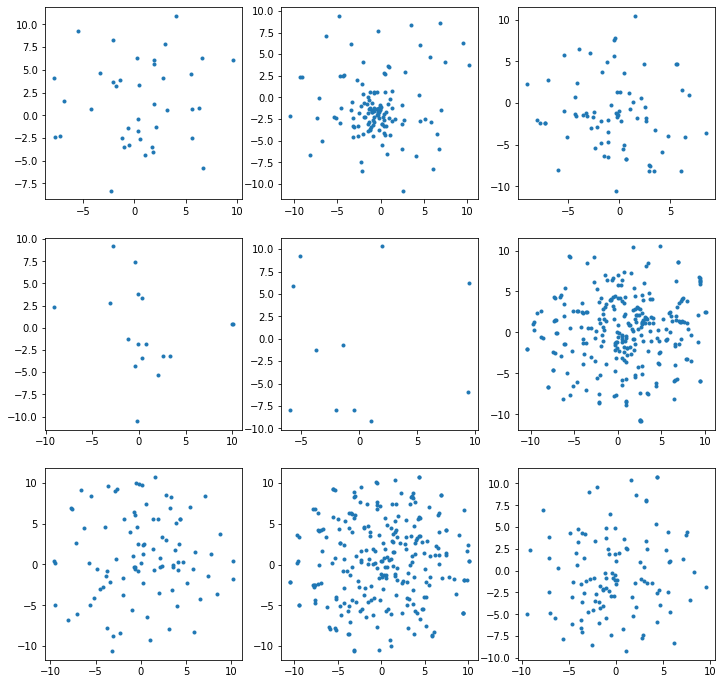

In [6]:
from sklearn.manifold import TSNE

Nrestriction = 1000;
Xembed = TSNE(n_components=2,perplexity=100,random_state=0).fit_transform(X_scaled[0:Nrestriction,:]);

plt.figure(figsize=(12,12))
for jj in range(9):
    restr = y_train.iloc[0:Nrestriction];
    restr = (restr==jj);
    plt.subplot(3,3,1+jj);
    plt.plot(Xembed[restr,0],Xembed[restr,1],'.');

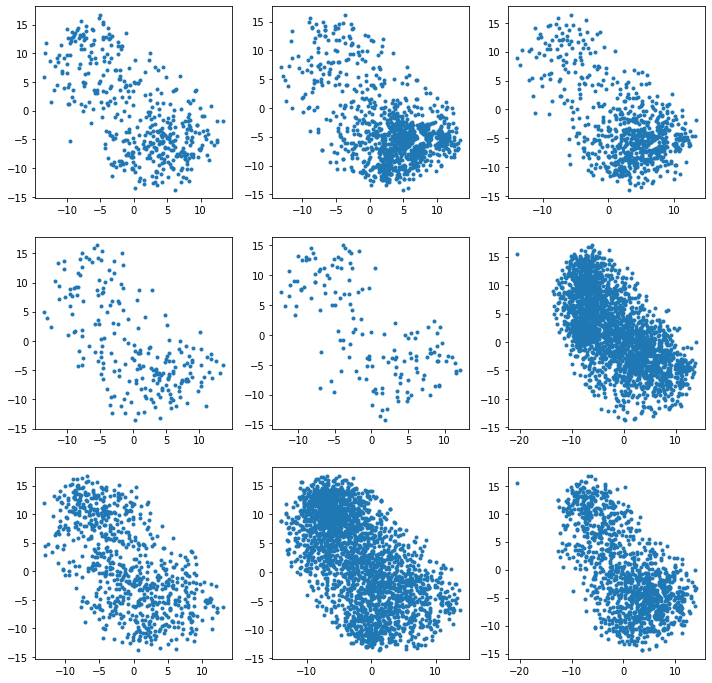

In [7]:
from sklearn.manifold import TSNE

Nrestriction = 10000;
Xembed = TSNE(n_components=2,perplexity=100,random_state=0).fit_transform(X_binary_scaled[0:Nrestriction,:]);

plt.figure(figsize=(12,12))
for jj in range(9):
    restr = y_train.iloc[0:Nrestriction];
    restr = (restr==jj);
    plt.subplot(3,3,1+jj);
    plt.plot(Xembed[restr,0],Xembed[restr,1],'.');

Note that after this point, I found results were better with the binary version of the data.

# PCA
The dataset has many features, but none are highly predictive of the target. PCA may be able to tell us if the dataset is actually of low dimension within the 75-dimension feature space, but only for linear combinations of features.

## Singular values
The singular values of the principal component analysis do indicate that there is a sharp drop-off in significance after the first few of the components; unfortunately, the magnitude do not decay rapidly, instead leveling off at a finite value; this indicates the data does not lie on a low-dimension linear subspace of the 75-dimension feature space.


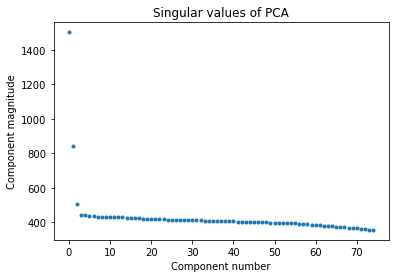

In [8]:
from sklearn.decomposition import PCA
pca = PCA();
X_pca = pca.fit_transform(X_binary_scaled);

plt.plot(pca.singular_values_,'.')
plt.xlabel('Component number');
plt.ylabel('Component magnitude');
plt.title('Singular values of PCA');

# TSNE on principal components
I apply TSNE on the PCA-transformed data, restricted to 10 principal components. My motivation here is that the leading principal components contain a lot of the information from the original data, and application of PCA may have compensated for relative "distances" or weightings between the columns.

Interestingly, the PCA-transformed data has much clearer clusters than the untransformed data. Unfortunately, it doesn't appear to be particularly useful for discriminating clusters; each class has roughly the same clusters. The only potentially useful thing I see is that one of the clusters in the second class seems to be smaller or more tightly grouped.

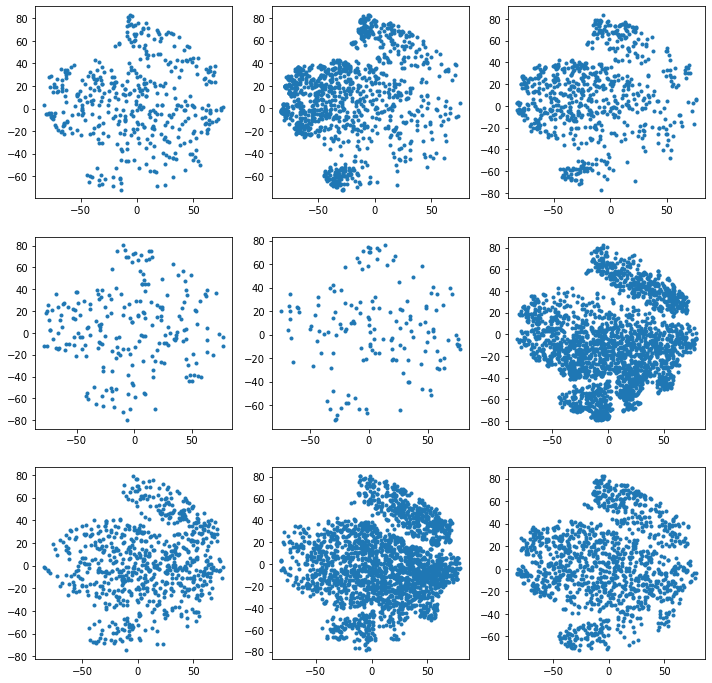

In [9]:
Nrestriction = 10000;
Xembed = TSNE(n_components=2,perplexity=30,random_state=1).fit_transform(X_pca[0:Nrestriction,0:10]);

plt.figure(figsize=(12,12))
for jj in range(9):
    restr = y_train.iloc[0:Nrestriction];
    restr = (restr==jj);
    plt.subplot(3,3,1+jj);
    plt.plot(Xembed[restr,0],Xembed[restr,1],'.');

# SVD / modified PCA
In standard PCA, the components are weighted by the singular values. Knowing that PCA is based on the singular value decomposition (SVD), I computed the SVD and applied TSNE to the components without weighting by singular values. The goal is further equalize distances when comparing features or composite features.

This again produces some clear clusters, but they don't seem meaningful for delineating classes.

In [10]:
from numpy.linalg import svd
u,s,vh = svd(X_binary_scaled,full_matrices=False);

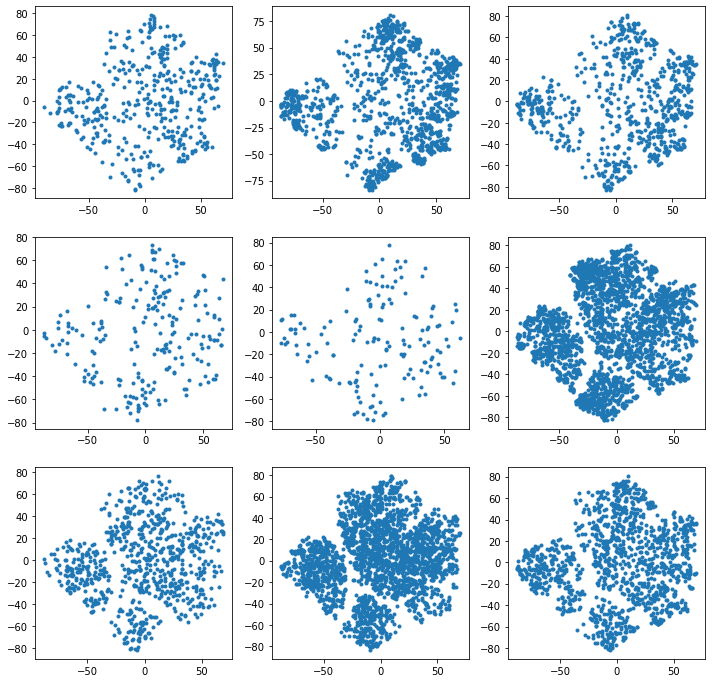

In [11]:
Nrestriction = 10000;
Xembed = TSNE(n_components=2,perplexity=30,random_state=0).fit_transform(u[0:Nrestriction,0:10]);

plt.figure(figsize=(12,12))
for jj in range(9):
    restr = y_train.iloc[0:Nrestriction];
    restr = (restr==jj);
    plt.subplot(3,3,1+jj);
    plt.plot(Xembed[restr,0],Xembed[restr,1],'.');